## Testing of trained models

### Imports

In [1]:
import torch
from IPython.display import display, HTML, Image
from torch_geometric.loader import DataLoader

from settings import *
from generator import generate_organism
from GNCAConv import Conv
from visualizer import Visualizer
from evo_trainer import Evo_Trainer
from enums import EnvironmentType, ModelType
from food_env import *
from online_tracker import OnlineTracker

### Helper methods

In [2]:
def get_default_settings(model_name): #the settings all models are trained on
    scale = 4
    wall_amount = 100*scale
    food_amount = 500*scale
    centered_env = Centered_Env(food_amount=food_amount, wall_amount=wall_amount//4)
    cluster_env = Cluster_Env(clusters=60*scale, cluster_size=15, wall_amount=wall_amount//3)
    circle_env = Circle_Env(circles=3*scale, food_amount=food_amount*2, wall_amount=wall_amount)
    spiral_env = Spiral_Env(spirals=3, food_amount=food_amount, wall_amount=wall_amount)
    bottleneck_env = Bottleneck_Env(food_amount=food_amount//3, wall_amount=(wall_amount*16)//25)
    grid_env = Grid_Env(cluster_size=30, grid_size=5*scale)
    lab_env = Labyrinth_Env(cluster_size=30, grid_size=3*scale)

    train_config = Train_Config(stdev=0.1, popsize=10, 
        name=model_name, problem_searcher=ProblemSearcher.CMAES,
        with_samplepool=False, timesteps=1000)

    settings = Settings(
        device = torch.device('cpu'),
        batch_size = 1,
        cells = 100,
        food_envs=[centered_env, cluster_env, circle_env, spiral_env, bottleneck_env, grid_env, lab_env],
        scale = scale,
        wrap_around = False,
        
        model_type = ModelType.Local,
        #model_type = ModelType.WithGlobalNode,
        #model_type = ModelType.SmallWorld,

        radius = 0.04,
        radius_food_scale = 5,
        consume_radius_scale = 0.8, 
        noise = 0.001,
        energy_required_to_replicate = 50,
        train_config=train_config,
        max_degree = 9,

        radius_wall_scale = 5,
        radius_wall_damage_scale = 3,
        wall_damage = 20,
        radius_long_scale=4,
    )
    return settings

In [3]:
def load_model(settings):
    model = Conv(settings=settings)
    model.load_state_dict(torch.load('../models/' + settings.train_config.name + '.pth'))
    return model

In [18]:
#Helper method for running a given model and setting config on each env type x times
def test_model(model, settings, times):
    food_dict = {}
    time_dict = {}

    for food_env in settings.food_envs:
        food_dict[food_env.env_type] = []
        time_dict[food_env.env_type] = []
        for _ in range(times//2): #batch size 2
            graphs = [generate_organism(settings).toGraph(food_env) for _ in range(settings.batch_size)]
            loader = DataLoader(graphs, batch_size=settings.batch_size)
            graph = next(iter(loader))
            with torch.no_grad():
                graph = model(graph, settings.train_config.timesteps)
            food_dict[food_env.env_type].extend(graph.food_reward.detach().numpy())
            time_dict[food_env.env_type].extend(graph.cells_alive.detach().numpy() / settings.n)
    return food_dict, time_dict

In [19]:
#Helper method for doing analysis on the results 
#?

In [20]:
#Helper method for plotting these results 
#maybe histplot/barplot with each model/env combo in each bar with average and best... at y
#show all models at each bar for each env so its easy to compare which models performs best on which envs

### Test models on trained env

In [21]:
#settings = get_default_settings('hidden15')
settings = get_default_settings('GAT1_localOnly')
model = load_model(settings)

food_dict, time_dict = test_model(model, settings, 10)
print(food_dict)
print(time_dict)

{<EnvironmentType.Centered: (1,)>: [0.0, 0.0, 0.0, 0.0, 0.0], <EnvironmentType.Clusters: (2,)>: [35.0, 145.0, 136.0, 2.0, 16.0], <EnvironmentType.Circular: (3,)>: [31.0, 126.0, 36.0, 96.0, 15.0], <EnvironmentType.Spiral: (4,)>: [248.0, 720.0, 311.0, 13.0, 194.0], <EnvironmentType.Bottleneck: (6,)>: [72.0, 76.0, 35.0, 53.0, 44.0], <EnvironmentType.Grid: (8,)>: [148.0, 132.0, 65.0, 150.0, 133.0], <EnvironmentType.Labyrinth: (5,)>: [69.0, 72.0, 61.0, 70.0, 48.0]}
{<EnvironmentType.Centered: (1,)>: [37.99, 38.0, 38.0, 38.0, 38.0], <EnvironmentType.Clusters: (2,)>: [42.81, 49.12, 70.33, 37.46, 40.91], <EnvironmentType.Circular: (3,)>: [35.25, 57.85, 44.99, 51.74, 41.23], <EnvironmentType.Spiral: (4,)>: [131.0, 218.87, 137.32, 41.6, 109.0], <EnvironmentType.Bottleneck: (6,)>: [49.25, 56.98, 43.53, 47.59, 46.28], <EnvironmentType.Grid: (8,)>: [75.69, 72.87, 53.77, 52.62, 75.39], <EnvironmentType.Labyrinth: (5,)>: [23.61, 30.23, 28.53, 29.76, 34.84]}


### Setup all testing options

In [8]:
#length of radius for edges
#amount of random noise
#graph size
#edges randomly cut
#nodes randomly removed
noise_options = [0.0, 0.002, 0.004, 0.008]
#noise in random nodes hidden states
#amount of food, food distribution...
#variate amount of cells

In [9]:
#update settings and everything to work with this
#create new visualizer

Make a plot simply on each model and environment type of how well they perform on different sizes of cells

### Test on specified options

In [10]:
#TODO somehow ensure we hardcoded test on one of each environment
graphs = [generate_organism(settings).toGraph() for _ in range(settings.batch_size)]
loader = DataLoader(graphs, batch_size=settings.batch_size)
graph = next(iter(loader))
visualizer = Visualizer(settings)
model(graph, 0)

DataBatch(x=[3833, 11], edge_index=[1, 0], device=[1], subsize=[1], velocity=[1], border_cost=[1], food_reward=[1], dead_cost=[1], visible_food=[1], food_avg_dist=[1], food_avg_degree=[1], food_search_movement=[1], cells_alive=[1], batch=[3833], ptr=[2])

### Visualize 

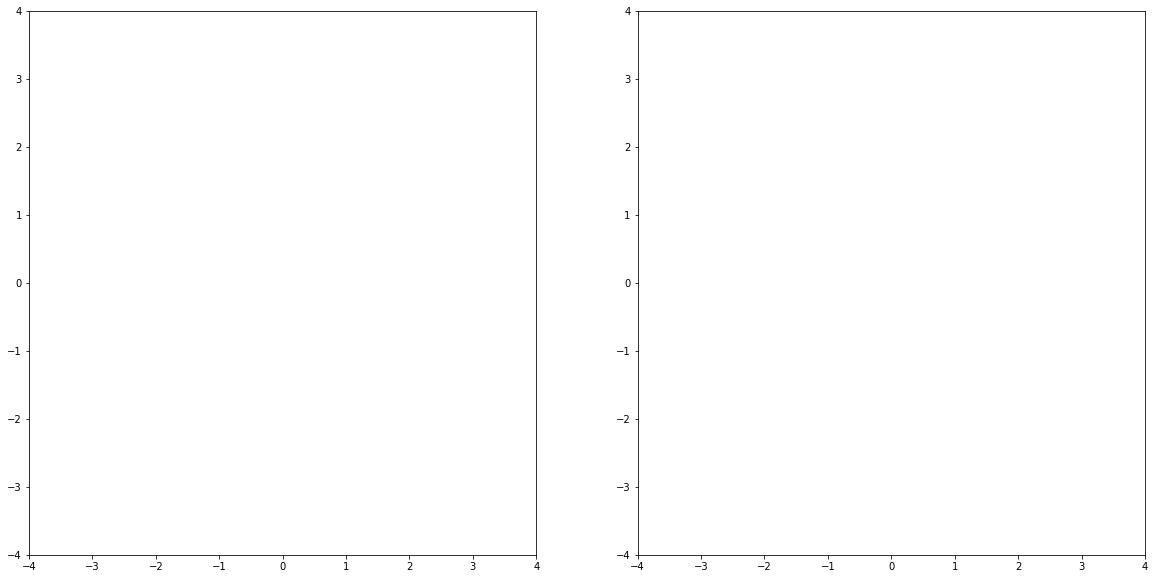

In [11]:
dpi = 100 #beautiful
#dpi = 50 #fast

anim = visualizer.animate_organism(graph, model) 
visualizer.save_animation_to_gif(anim, settings.train_config.name + '_test1', fps=10, dpi=dpi)

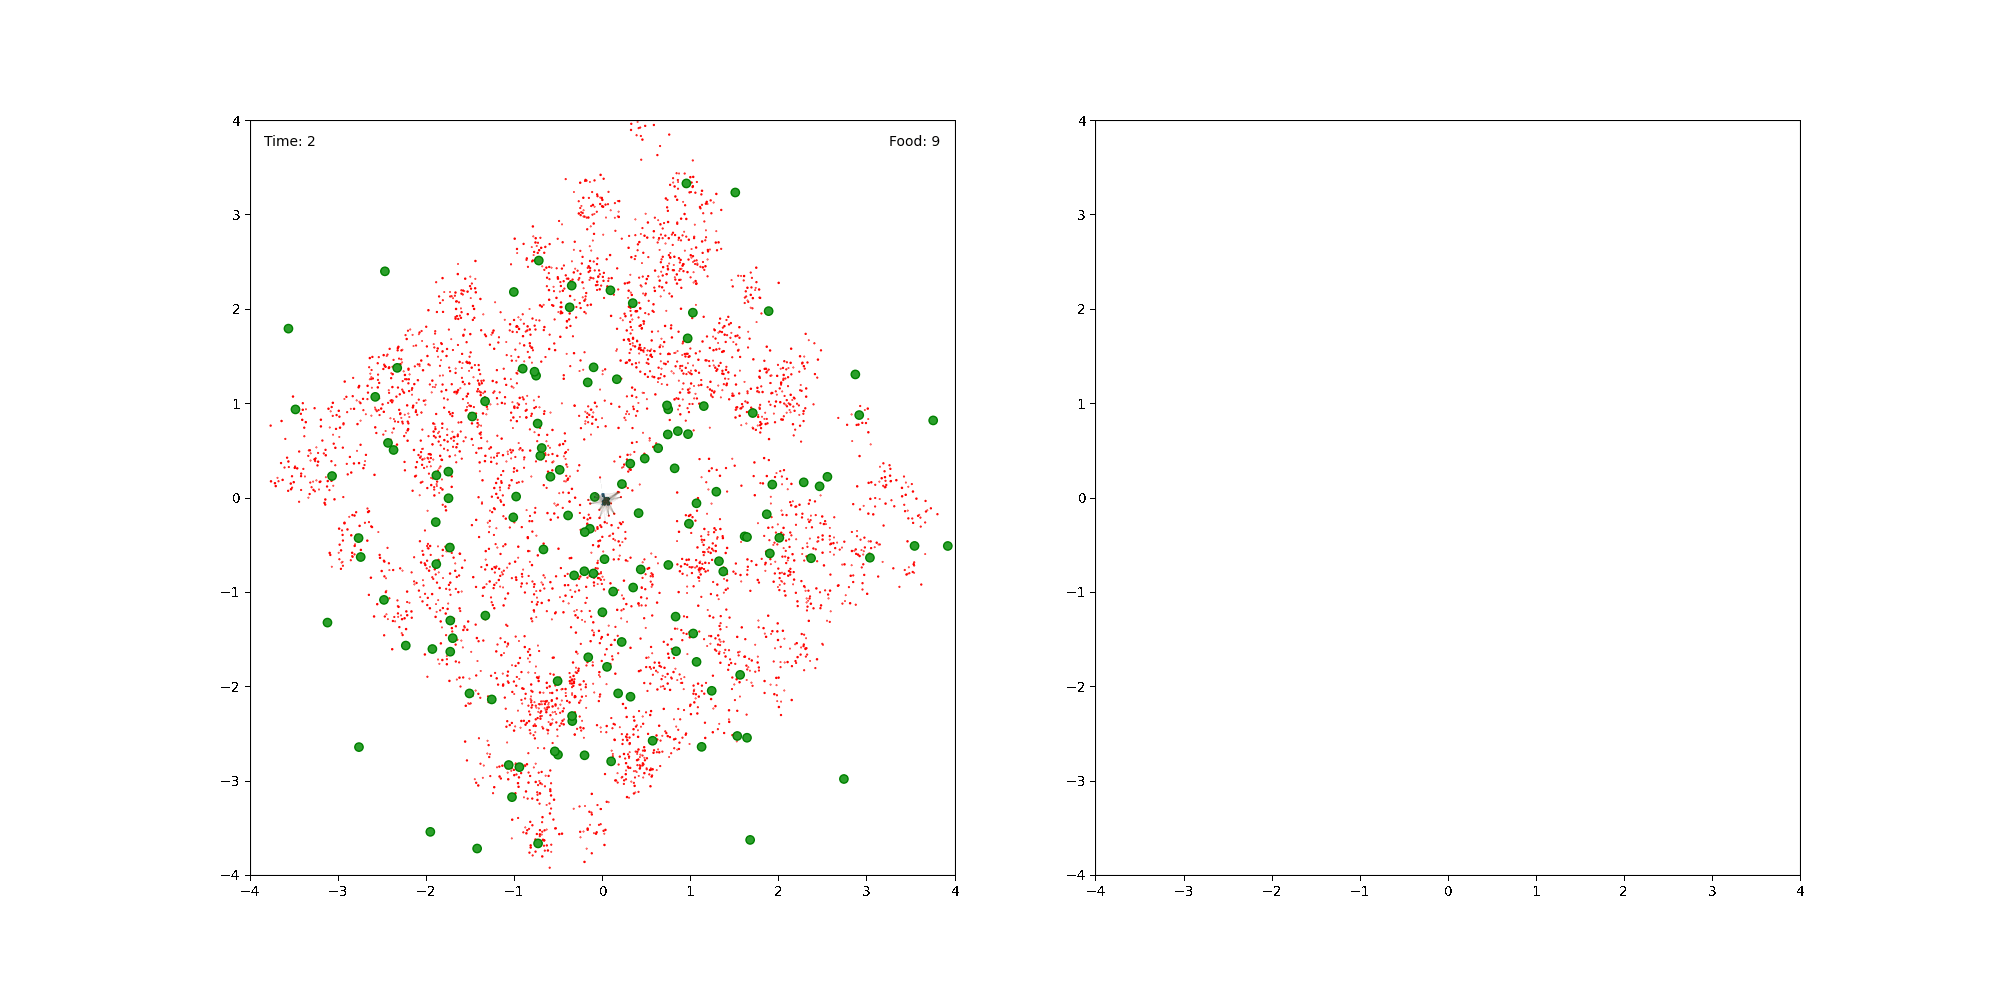

In [13]:
Image('../animation/' + settings.train_config.name + '_test1.gif')

### Plot average of performance on different settings for each mode type

perform x tests on each configuration for each mode and see which performs best in each and across each config

In [ ]:
#

### Benchmarking

need some benchmarkings in how fast each models work on different sizes depending on food and cells..
Plot size on x and time on y

To know how well the framework scales